In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as scp
import glob
import h5py
import os

# Structure of data looks the same as MERFISH MOp dataset

* There is a global coordinate system used (which is great)
* Cell boundaries are saved as deeply nested hdf5 files
* Different features (field of views?) are saved as different hdf5s
* RNA spot locations are separately saved as CSVs
* Cell-type annotation data is contained in the h5ad files (three alternate approaches were used to annotate cells)

I need to identify which RNA spot belongs to which cell and make my own hdf5 objects

In [100]:
stem = '/oak/stanford/groups/horence/rob/isoform_localizations/SRRS/preprocessing/KidneyLiver_preprocessing/data'

## The RNA-spot x,y coordinates are in the cell_boundary zips at the first level



In [122]:
spots_path = os.path.join(stem,'VZG116','MsKidney_CellBoundary_VZG116_111921','barcodes.csv')
spots_df = pd.read_csv(spots_path,nrows=10, index_col=0)
spots_df

,barcode_id,global_x,global_y,global_z,x,y,fov
15027,1,60.294850,4139.9907,0.0,558.28564,1293.2473,0
15378,1,39.915333,4147.5140,1.0,369.58640,1362.9089,0
15711,1,39.696377,4146.4930,2.0,367.55905,1353.4525,0
15714,1,38.378930,4147.7925,2.0,355.36044,1365.4845,0
17381,2,42.090202,4172.0874,0.0,389.72410,1590.4384,0
17389,2,44.631676,4177.0527,0.0,413.25626,1636.4127,0
17399,2,124.657970,4182.4110,0.0,1154.24040,1686.0298,0
17404,2,72.460770,4185.3057,0.0,670.93304,1712.8289,0
17413,2,189.540280,4187.7754,0.0,1755.00260,1735.6995,0
17589,2,123.952400,4170.2866,1.0,1147.70740,1573.7634,0


# The cell boundary zips have hdf5's and metadata

I first extracted the following hdf5 from the zip by `unzip -p MsKidney_CellBoundary_VZG116_111921.zip MsKidney_CellBoundary_VZG116_111921/features/feature_data_426.hdf5 > feature_data_426.hdf5`

Then after all the unzipping I've just chosen feature 0

In [102]:
boundary_path = 'VZG116/MsKidney_CellBoundary_VZG116_111921/features/feature_data_0.hdf5'
h5_path = os.path.join(stem,boundary_path)
f = h5py.File(h5_path,'r')
f

<HDF5 file "feature_data_0.hdf5" (mode r)>

In [103]:
#Top level just has a single group and no attrs
print(dict(f.attrs))
print(f.keys())

{}
<KeysViewHDF5 ['featuredata']>


In [104]:
#The featuredata group has a version tag attribute
#and then an individual group for each cell keyed by cell-id
print(dict(f['featuredata'].attrs))
print(f['featuredata'].keys())

{'version': '0.1.9'}
<KeysViewHDF5 ['100103156195484539835846679900152827019', '100299055550742403838736454416457106378', '100508361727354390246543055490415090933', '101476277448225652664802681520983252404', '103728463955077055232451996731088051447', '104222948928279623114028829933895195341', '104526801981315108965592901153246583246', '105309408644564871164037469359287068640', '106370707215343124060643694237623883399', '106405441000697822475815192626529379185', '106663001722679040094866384247355692679', '107126195243196220662672457467932423550', '107340917873496722391902389343930622568', '108158240686793044318395000820003537507', '108878020415038133139664278871321516822', '111163574283754754217026357403380102771', '111543161655411050871845493560418495536', '112270083282318023924975570120851178170', '112725371820061477285802187269861341457', '112857067947364058072808131010050699657', '114493660372516245977362155515229273451', '114629009470983925689809934313144542720', '11577965621022429

In [105]:
#A cell group has bounding box attributes, fov, cell_id, and volume
#Then it has groups for the different z-slices, and a z_coordinates group
print(dict(f['featuredata']['100103156195484539835846679900152827019'].attrs))
print(f['featuredata']['100103156195484539835846679900152827019'].keys())

{'bounding_box': array([ 189.88422668, 4022.99589622,  190.46207989, 4023.50662963]), 'fov': 0, 'id': b'100103156195484539835846679900152827019', 'volume': 0.08124806670594717}
<KeysViewHDF5 ['zIndex_0', 'zIndex_1', 'zIndex_2', 'zIndex_3', 'zIndex_4', 'zIndex_5', 'zIndex_6', 'z_coordinates']>


In [106]:
#The z_coordinates is a list of the depth in microns of each slice
print(f['featuredata']['100103156195484539835846679900152827019']['z_coordinates'][:])

[ 1.5  3.   4.5  6.   7.5  9.  10.5]


In [107]:
#Within each z-slice there is another group. I don't know why though..
#ok I've checked below, and every z-slice only has a single p_0 group (in this hdf5 subset at least)
print(dict(f['featuredata']['100103156195484539835846679900152827019']['zIndex_0'].attrs))
print(f['featuredata']['100103156195484539835846679900152827019']['zIndex_0'].keys())

{}
<KeysViewHDF5 ['p_0']>


In [108]:
#There is another group within p which has the actual cell boundary polygons
print(dict(f['featuredata']['100103156195484539835846679900152827019']['zIndex_0']['p_0'].attrs))
print(f['featuredata']['100103156195484539835846679900152827019']['zIndex_0']['p_0'].keys())

{'type': b'Polygon'}
<KeysViewHDF5 ['coordinates']>


In [109]:
#The coordinates dataset doesn't have attributes, and is 3D, but only uses two axes
print(dict(f['featuredata']['100103156195484539835846679900152827019']['zIndex_0']['p_0']['coordinates'].attrs))
print(f['featuredata']['100103156195484539835846679900152827019']['zIndex_0']['p_0']['coordinates'])

{}
<HDF5 dataset "coordinates": shape (1, 89, 2), type "<f8">


In [110]:
#Can extract the 2D polygon points using:
f['featuredata']['100103156195484539835846679900152827019']['zIndex_0']['p_0']['coordinates'][0,:,:].shape

(89, 2)

In [127]:
f['featuredata']['100103156195484539835846679900152827019']['zIndex_0']['p_0']['coordinates'][0,:,:]

array([[ 189.99222669, 4023.50662963],
       [ 189.99900806, 4023.50641652],
       [ 190.00576268, 4023.50577802],
       [ 190.01246387, 4023.50471665],
       [ 190.01908519, 4023.50323661],
       [ 190.02560052, 4023.50134373],
       [ 190.03198414, 4023.49904549],
       [ 190.03821085, 4023.49635095],
       [ 190.04425608, 4023.49327075],
       [ 190.05009598, 4023.48981705],
       [ 190.05570749, 4023.48600347],
       [ 190.06106848, 4023.48184506],
       [ 190.06615777, 4023.47735824],
       [ 190.0709553 , 4023.47256072],
       [ 190.07544212, 4023.46747142],
       [ 190.07960052, 4023.46211044],
       [ 190.0834141 , 4023.45649892],
       [ 190.08686781, 4023.45065903],
       [ 190.08994801, 4023.44461379],
       [ 190.09264255, 4023.35887217],
       [ 190.08994801, 4023.35264546],
       [ 190.08686781, 4023.34660023],
       [ 190.0834141 , 4023.34076033],
       [ 190.07960052, 4023.33514882],
       [ 190.07544212, 4023.32978783],
       [ 190.0709553 , 40

In [124]:
len(f['featuredata']['100103156195484539835846679900152827019']['zIndex_0'])

1

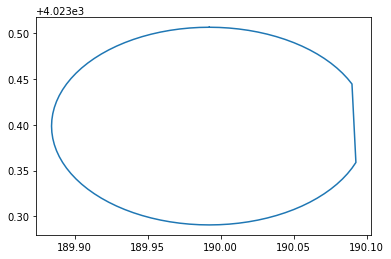

In [111]:
#
pts = f['featuredata']['100103156195484539835846679900152827019']['zIndex_0']['p_0']['coordinates'][0,:,:]
xs = pts[:,0]
ys = pts[:,1]
plt.plot(xs,ys)
plt.show()
plt.close()

In [112]:
#the bounding box makes sense with the cell shape above
#so I think I've gotten the x and y points in the correct order
f['featuredata']['100103156195484539835846679900152827019'].attrs['bounding_box']

array([ 189.88422668, 4022.99589622,  190.46207989, 4023.50662963])

## Below is showing that there are just 1 "p-groups" in each z-slice group

And sometimes 0 if that z-slice doesn't have any data

In [113]:
cell_ps = {
    'cell_id':[],
    'num_zs':[],
    'z':[],
    'num_ps_at_z':[],
}

for cell_id in f['featuredata']:
    cell = f['featuredata'][cell_id]
    for i,z in enumerate(cell['z_coordinates']):
        z_slice = cell['zIndex_{}'.format(i)]
        num_ps = sum(1 for p in z_slice)
        
        cell_ps['cell_id'].append(cell_id)
        cell_ps['num_zs'].append(len(cell['z_coordinates']))
        cell_ps['z'].append('zIndex_{}'.format(i))
        cell_ps['num_ps_at_z'].append(num_ps)
        
cell_ps_df = pd.DataFrame(cell_ps)
cell_ps_df

,cell_id,num_zs,z,num_ps_at_z
0,100103156195484539835846679900152827019,7,zIndex_0,1
1,100103156195484539835846679900152827019,7,zIndex_1,1
2,100103156195484539835846679900152827019,7,zIndex_2,0
3,100103156195484539835846679900152827019,7,zIndex_3,0
4,100103156195484539835846679900152827019,7,zIndex_4,0
...,...,...,...,...
3110,99742140856582517701933144235126120651,7,zIndex_2,1
3111,99742140856582517701933144235126120651,7,zIndex_3,0
3112,99742140856582517701933144235126120651,7,zIndex_4,0
3113,99742140856582517701933144235126120651,7,zIndex_5,0


In [97]:
#Even if a cell doesn't have info at all z-slices, the z_coordinates will always list all
cell_ps_df['num_zs'].value_counts()

7    3115
Name: num_zs, dtype: int64

3.0

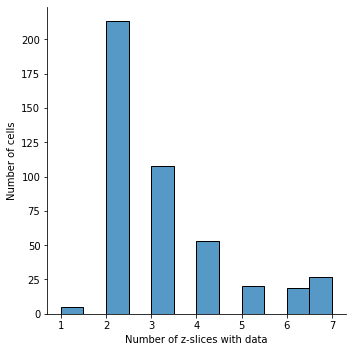

In [98]:
#The median number of non-empty z-slices per cell is 3
zs_with_data_per_cell = cell_ps_df.groupby('cell_id')['num_ps_at_z'].apply(lambda x: sum(x > 0))
display(zs_with_data_per_cell.median())
sns.displot(zs_with_data_per_cell)
plt.xlabel('Number of z-slices with data')
plt.ylabel('Number of cells')
plt.show()
plt.close()

In [99]:
#At most, each z-slice has a single p-group
cell_ps_df['num_ps_at_z'].max()

1

# The h5ad files have cell x gene counts

There are 3 types of h5ad files for each tissue (Liver and Kidney)

The VI stands for "Variational Inference"

1. [scANVI](https://www.embopress.org/doi/full/10.15252/msb.20209620) h5ads are MERFISH cells with cell-types called by an algorithm scANVI that predicts cell-type labels and is trained on the Tabula Muris Senis dataset

2. [scVI](https://www.nature.com/articles/s41592-018-0229-2) was an alternative approach to assign cell-types to the MERFISH cells

3. MERFISH which has cell-types determined just by the MERFISH data, without leveraging any outside data

In [116]:
liver_adata = scp.read_h5ad(os.path.join(stem,'cell_gene_counts','MERFISH_liver_object.h5ad'))
liver_adata

AnnData object with n_obs × n_vars = 19695 × 307
    obs: 'fov', 'volume', 'center_x', 'center_y', 'min_x', 'max_x', 'min_y', 'max_y', 'median average DAPI', 'mean average DAPI', 'dataset', 'barcodeCount', 'n_counts', 'leiden', 'tentative_annot'
    uns: 'QC_filter', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups', 'tentative_annot_colors', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [117]:
#Kidney scANVI 34,387 cells by 306 genes (cell-types called by scANVI which is trained on Tabula Muris)
adata = scp.read_h5ad(os.path.join(stem,'cell_gene_counts','scANVI_kidney_object.h5ad'))
adata

AnnData object with n_obs × n_vars = 34387 × 306
    obs: 'age', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'n_genes', 'sex', 'subtissue', 'tissue', 'tissue_free_annotation', 'n_counts', 'fov', 'volume', 'center_x', 'center_y', 'min_x', 'max_x', 'min_y', 'max_y', 'median average DAPI', 'mean average DAPI', 'dataset', 'barcodeCount', 'tech', 'celltype_scanvi', '_scvi_batch', '_scvi_labels', 'predicted_cell_type'
    var: 'n_cells-scRNA-seq'
    uns: 'C_scANVI_colors', '_scvi', 'neighbors', 'tech_colors', 'umap'
    obsm: 'X_scANVI', 'X_umap', 'spatial'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [118]:
#Kidney scANVI 36,714 cells by 306 genes
adata = scp.read_h5ad(os.path.join(stem,'cell_gene_counts','scVI_kidney_object.h5ad'))
adata

AnnData object with n_obs × n_vars = 36714 × 306
    obs: 'age', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'n_genes', 'sex', 'subtissue', 'tissue', 'tissue_free_annotation', 'n_counts', 'fov', 'volume', 'center_x', 'center_y', 'min_x', 'max_x', 'min_y', 'max_y', 'median average DAPI', 'mean average DAPI', 'dataset', 'barcodeCount', 'tech', 'celltype_scanvi', '_scvi_batch', '_scvi_labels', 'predicted_cell_type'
    var: 'n_cells-scRNA-seq'
    uns: 'C_scANVI_colors', '_scvi', 'neighbors', 'tech_colors', 'umap'
    obsm: 'X_scANVI', 'X_umap'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [119]:
#Liver scANVI 19,698 cells by 306 genes
adata = scp.read_h5ad(os.path.join(stem,'cell_gene_counts','scANVI_liver_object.h5ad'))
adata

AnnData object with n_obs × n_vars = 19698 × 306
    obs: 'age', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'n_genes', 'sex', 'subtissue', 'tissue', 'tissue_free_annotation', 'integrated_manually_annotated', 'batch', 'n_counts', 'fov', 'volume', 'center_x', 'center_y', 'min_x', 'max_x', 'min_y', 'max_y', 'median average DAPI', 'mean average DAPI', 'dataset', 'barcodeCount', 'tech', 'celltype_scanvi', '_scvi_batch', '_scvi_labels', 'predicted_cell_type'
    var: 'n_cells-scRNA-seq'
    uns: 'C_scANVI_colors', '_scvi', 'neighbors', 'tech_colors', 'umap'
    obsm: 'X_scANVI', 'X_umap', 'spatial'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [120]:
#Liver scANVI 22,019 cells by 306 genes
adata = scp.read_h5ad(os.path.join(stem,'cell_gene_counts','scVI_liver_object.h5ad'))
adata

AnnData object with n_obs × n_vars = 22019 × 306
    obs: 'age', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'n_genes', 'sex', 'subtissue', 'tissue', 'tissue_free_annotation', 'integrated_manually_annotated', 'batch', 'n_counts', 'fov', 'volume', 'center_x', 'center_y', 'min_x', 'max_x', 'min_y', 'max_y', 'median average DAPI', 'mean average DAPI', 'dataset', 'barcodeCount', 'tech', 'celltype_scanvi', '_scvi_batch', '_scvi_labels', 'predicted_cell_type'
    var: 'n_cells-scRNA-seq'
    uns: 'C_scANVI_colors', '_scvi', 'neighbors', 'tech_colors', 'umap'
    obsm: 'X_scANVI', 'X_umap'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

# SLRRP hdf5 format

In [128]:
f = h5py.File('../inputs/m1s1_subset.hdf5','r')

In [131]:
dict(f.attrs)

{}

In [132]:
f.keys()

<KeysViewHDF5 ['cell_ids', 'cells', 'genes']>

In [134]:
f['cells'].keys()

<KeysViewHDF5 ['100090299132393774825374529480599642352', '102762322167228082486052775619884277102', '103963394979214788325793179983943807873', '104773525917171323315032845506736864421', '104887114217211410540888577620028568901', '106736575396305345683133461207739252997', '106771113274834466403933341586053551462', '111300904473796808480218743996654298162', '114601597319929030309061287706907914361', '114794480420405132420944298037591232478', '116545673785912319834287485202909229480', '116958434959714719022853807486346359847', '117278462105927683058902716691567767060', '118363099495240822175959718080964460592', '120885533126383545294034624420296038166', '131839580702053878622895713282850418670', '135221636419407451803412415350214899881', '140363262818590467334221980287927834774', '142291509029169734847215347686657429197', '142822951347518090322234372274331862666', '145531913712168956084196484724954151860', '145731456902179856722061144755427589556', '14602548646116620210766874686980335970

In [136]:
dict(f['cells']['7973318325035700141523338287728614297'].attrs)

{'annotation': 'unannotated',
 'num_genes': 90,
 'num_spots': 690,
 'zslices': array(['0', '1', '2', '3', '4', '5', '6'], dtype=object)}

In [137]:
f['cells']['7973318325035700141523338287728614297'].keys()

<KeysViewHDF5 ['boundaries', 'gene_vars', 'spot_coords', 'spot_genes']>

In [139]:
f['cells']['7973318325035700141523338287728614297']['spot_genes'].keys()

<KeysViewHDF5 ['0', '1', '2', '3', '4', '5', '6']>

In [141]:
7.encode()

SyntaxError: invalid syntax (<ipython-input-141-f088b645d102>, line 1)

In [142]:
'7'.encode()

b'7'